이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

### 필요한 모듈을 가져오세요.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import mean_squared_error, silhouette_score

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

### 위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [2]:
!kaggle datasets download -d zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
fashionmnist.zip: Skipping, found more recently modified local copy (use --force to force download)


### 데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [3]:
# 데이터 로드
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# 데이터 요약 및 정보
print(f"Train data shape: {train_data.data.shape}")
print(f"Test data shape: {test_data.data.shape}")
print(f"Train labels unique counts: {np.unique(train_data.targets.numpy(), return_counts=True)}")
print(f"Test labels unique counts: {np.unique(test_data.targets.numpy(), return_counts=True)}")

Train data shape: torch.Size([60000, 28, 28])
Test data shape: torch.Size([10000, 28, 28])
Train labels unique counts: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))
Test labels unique counts: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


### Data중 첫 번째 이미지를 보여주세요.

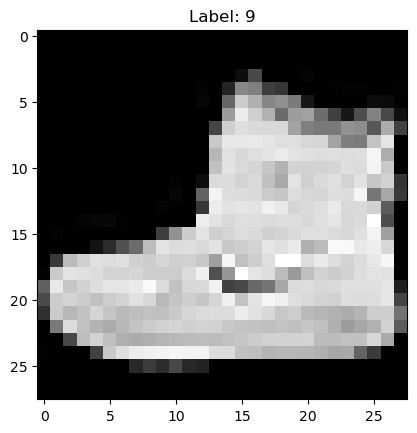

In [4]:
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title(f"Label: {train_data.targets[0].item()}")
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [5]:
train_data_normalized = train_data.data.float() / 255
test_data_normalized = test_data.data.float() / 255

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

- PCA (Principal Component Analysis) : 고차원 데이터를 주요 성분으로 변환하여 차원을 축소하는 기법
- T-SNE (t-distributed Stochastic Neighbor Embedding) : 비선형 차원 축소 방법으로, 데이터의 근접성을 보존하며 고차원 데이터를 저차원으로 변환해 클러스터 구조를 강조

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
train_data_flat = np.array(train_data_normalized.detach().cpu().numpy(), dtype=np.float32).reshape(len(train_data_normalized), -1).copy()

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data_flat)

pca = PCA(n_components=50)
X_pca50 = pca.fit_transform(train_data_scaled)

### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [8]:
explained_variance_ratio_50 = pca.explained_variance_ratio_.sum()
print("Explained Variance Ratio (50 components):", explained_variance_ratio_50)

Explained Variance Ratio (50 components): 0.80064476


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [9]:
train_pca_inverse_50 = pca.inverse_transform(X_pca50)
reconstruction_error_50 = mean_squared_error(train_data_scaled, train_pca_inverse_50)
print("Reconstruction Error (50 components):", reconstruction_error_50)


Reconstruction Error (50 components): 0.19934767


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [10]:
pca_30 = PCA(n_components=30)
X_pca30 = pca_30.fit_transform(train_data_scaled)

# 설명된 분산 비율 계산
explained_variance_ratio_30 = pca_30.explained_variance_ratio_.sum()
print("Explained Variance Ratio (30 components):", explained_variance_ratio_30)

# 재구성 오차 계산
train_pca_inverse_30 = pca_30.inverse_transform(X_pca30)
reconstruction_error_30 = mean_squared_error(train_data_scaled, train_pca_inverse_30)
print("Reconstruction Error (30 components):", reconstruction_error_30)


Explained Variance Ratio (30 components): 0.74418014
Reconstruction Error (30 components): 0.2558109


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [11]:
# PCA를 사용해 2차원으로 차원 축소
pca_2 = PCA(n_components=2)
X_pca2 = pca_2.fit_transform(train_data_scaled)

# 설명된 분산 비율 계산
explained_variance_ratio_2 = pca_2.explained_variance_ratio_.sum()
print("Explained Variance Ratio (2 components):", explained_variance_ratio_2)

# 재구성 오차 계산
train_pca_inverse_2 = pca_2.inverse_transform(X_pca2)
reconstruction_error_2 = mean_squared_error(train_data_scaled, train_pca_inverse_2)
print("Reconstruction Error (2 components):", reconstruction_error_2)

Explained Variance Ratio (2 components): 0.3649822
Reconstruction Error (2 components): 0.6350055


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

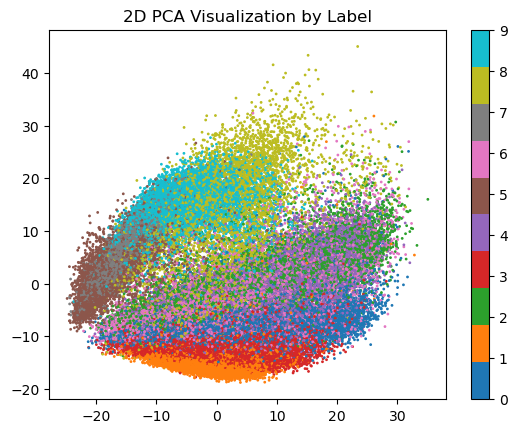

In [12]:
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=train_data.targets.numpy(), cmap='tab10', s=1)
plt.colorbar()
plt.title("2D PCA Visualization by Label")
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

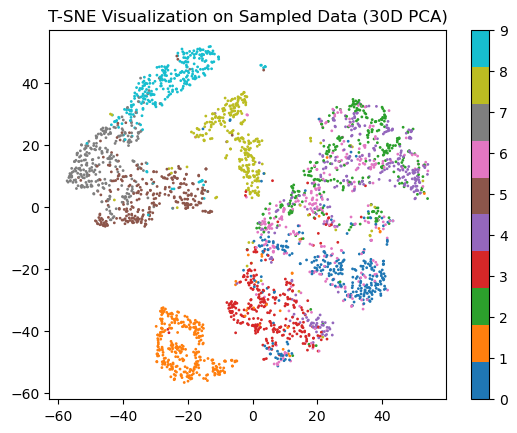

In [13]:
from sklearn.manifold import TSNE
from threadpoolctl import threadpool_limits
import matplotlib.pyplot as plt
import numpy as np

# 샘플 데이터 선택 
sample_size = 3000
np.random.seed(42)
indices = np.random.choice(X_pca30.shape[0], sample_size, replace=False)
X_sample = X_pca30[indices]
y_sample = train_data.targets.numpy()[indices]

# T-SNE 2D 변환 (threadpoolctl을 사용해 스레드 수 제한)
with threadpool_limits(limits=1, user_api='blas'):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne_30_sample = tsne.fit_transform(X_sample)

# T-SNE 결과 시각화
plt.scatter(X_tsne_30_sample[:, 0], X_tsne_30_sample[:, 1], c=y_sample, cmap='tab10', s=1)
plt.colorbar()
plt.title("T-SNE Visualization on Sampled Data (30D PCA)")
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

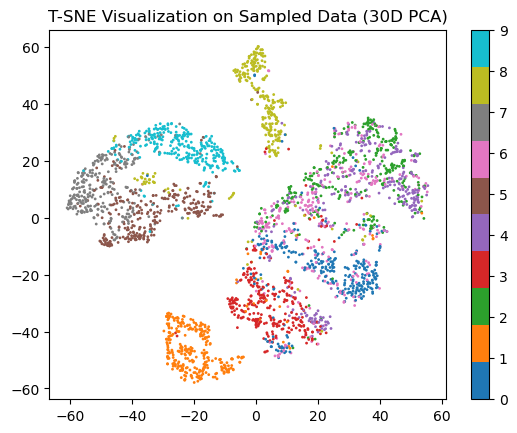

In [14]:
X_tsne_30_sample = tsne.fit_transform(X_sample)

# T-SNE 결과 시각화
plt.scatter(X_tsne_30_sample[:, 0], X_tsne_30_sample[:, 1], c=y_sample, cmap='tab10', s=1)
plt.colorbar()
plt.title("T-SNE Visualization on Sampled Data (30D PCA)")
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

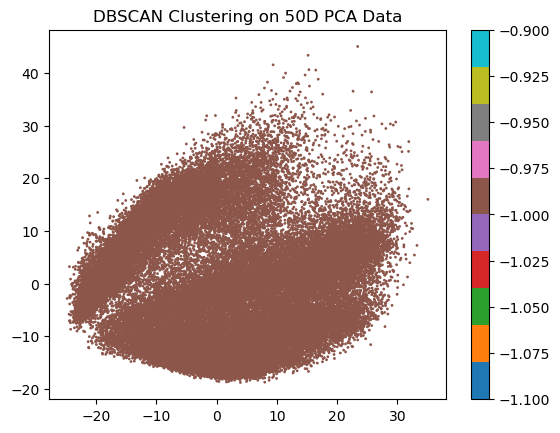

In [15]:
dbscan = DBSCAN()
clusters_dbscan = dbscan.fit_predict(X_pca50)

# DBSCAN 결과 시각화
plt.scatter(X_pca50[:, 0], X_pca50[:, 1], c=clusters_dbscan, cmap='tab10', s=1)
plt.colorbar()
plt.title("DBSCAN Clustering on 50D PCA Data")
plt.show()

### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

/Users/nawon/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


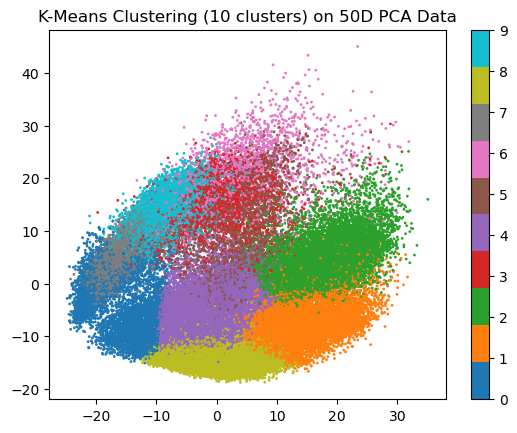

In [16]:
kmeans_10 = KMeans(n_clusters=10, random_state=42)
clusters_kmeans_10 = kmeans_10.fit_predict(X_pca50)

# K-Means 결과 시각화
plt.scatter(X_pca50[:, 0], X_pca50[:, 1], c=clusters_kmeans_10, cmap='tab10', s=1)
plt.colorbar()
plt.title("K-Means Clustering (10 clusters) on 50D PCA Data")
plt.show()

### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

/Users/nawon/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nawon/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nawon/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nawon/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

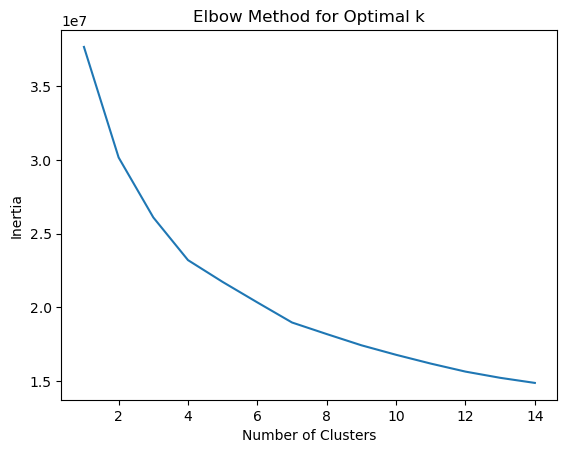

In [17]:
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca50)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 15), inertia)
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

/Users/nawon/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


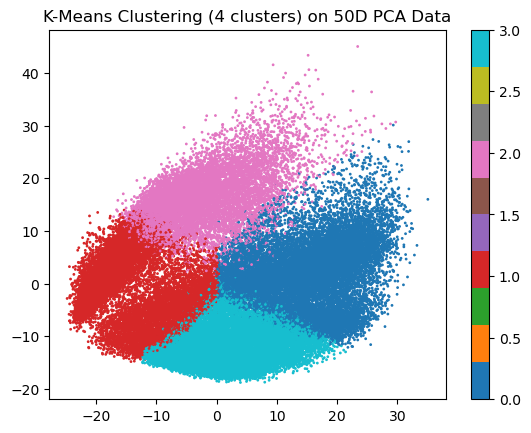

In [18]:
optimal_k = 4 
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
clusters_kmeans_optimal = kmeans_optimal.fit_predict(X_pca50)

# 클러스터링 결과 시각화
plt.scatter(X_pca50[:, 0], X_pca50[:, 1], c=clusters_kmeans_optimal, cmap='tab10', s=1)
plt.colorbar()
plt.title(f"K-Means Clustering ({optimal_k} clusters) on 50D PCA Data")
plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

In [19]:
!pip install hdbscan

  Obtaining dependency information for hdbscan from https://files.pythonhosted.org/packages/f9/42/5a092661e98682fd2dd7b7afde1e5264f56b0882e0893334bf5f3eb01f32/hdbscan-0.8.39-cp311-cp311-macosx_10_9_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.1 MB/s eta 0:00:0000:0100:010m


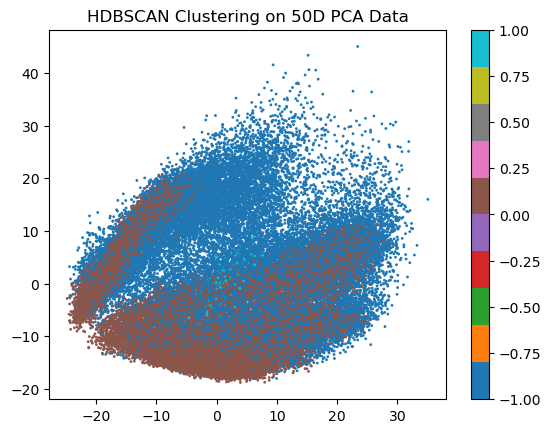

In [20]:
import hdbscan

hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=50)
clusters_hdbscan = hdbscan_cluster.fit_predict(X_pca50)

plt.scatter(X_pca50[:, 0], X_pca50[:, 1], c=clusters_hdbscan, cmap='tab10', s=1)
plt.colorbar()
plt.title("HDBSCAN Clustering on 50D PCA Data")
plt.show()

/Users/nawon/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


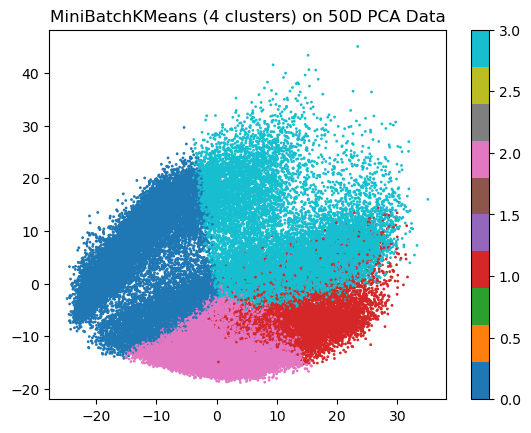

In [21]:
from sklearn.cluster import MiniBatchKMeans

# MiniBatchKMeans 군집화 수행
mini_kmeans = MiniBatchKMeans(n_clusters=optimal_k, batch_size=100, random_state=42)
clusters_mini_kmeans = mini_kmeans.fit_predict(X_pca50)

# 결과 시각화
plt.scatter(X_pca50[:, 0], X_pca50[:, 1], c=clusters_mini_kmeans, cmap='tab10', s=1)
plt.colorbar()
plt.title(f"MiniBatchKMeans ({optimal_k} clusters) on 50D PCA Data")
plt.show()

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

In [24]:
from sklearn.metrics import silhouette_score

# Silhouette Score를 계산하기 위한 각 모델의 결과 저장
scores = {}

# KMeans
kmeans_score = silhouette_score(X_pca50, clusters_kmeans)
scores['KMeans'] = kmeans_score

# DBSCAN
if len(set(clusters_dbscan)) > 1:  
    dbscan_score = silhouette_score(X_pca50, clusters_dbscan)
    scores['DBSCAN'] = dbscan_score
else:
    scores['DBSCAN'] = "Silhouette score not applicable (only one cluster)"

# MiniBatchKMeans
mini_kmeans_score = silhouette_score(X_pca50, clusters_mini_kmeans)
scores['MiniBatchKMeans'] = mini_kmeans_score

# HDBSCAN
if len(set(clusters_hdbscan)) > 1: 
    hdbscan_score = silhouette_score(X_pca50, clusters_hdbscan)
    scores['HDBSCAN'] = hdbscan_score
else:
    scores['HDBSCAN'] = "Silhouette score not applicable (only one cluster)"

# 결과 출력
for model_name, score in scores.items():
    print(f"{model_name}: Silhouette Score = {score}")

KMeans: Silhouette Score = 0.1852036565542221
DBSCAN: Silhouette Score = Silhouette score not applicable (only one cluster)
MiniBatchKMeans: Silhouette Score = 0.1552424430847168
HDBSCAN: Silhouette Score = 0.006569423712790012


### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

KMeans가 가장 높은 실루엣 점수로 군집화 성능이 가장 좋음.
DBSCAN과 HDBSCAN은 데이터에 적합하지 않아 하나의 군집 혹은 매우 낮은 점수 기록.
MiniBatchKMeans는 속도 면에서 이점이 있으며 KMeans와 비슷한 성능을 보임.